# Complete ReadMe Example

> **Note:**  
> This notebook includes **interactive map visualizations** using the `geemap` package, organizes data using `pandas` for plotting, and plots data using the `matplotlib` package. 
> Additionally, you will likely need to install `ipykernel` to utilize the interactive elements within a Jupyter Notebook.
> The `geemap`, `matplotlib`, and `ipykernel` packages are **not installed automatically** with `RadGEEToolbox` since they are optional dependencies focused on visualizations. 
> If you have not already installed these packages, you can do so with:
>
> ```bash
> pip install geemap ipykernel matplotlib
> ```
>
> Alternatively, using conda:
>
> ```bash
> conda install conda-forge::geemap anaconda::ipykernel conda-forge::matplotlib
> ```
>  
> If you do not install them, the map-based portions of this notebook will not work.

In [1]:
# 1. Import necessary packages and modules
import ee
from RadGEEToolbox import LandsatCollection, VisParams
import geemap
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator
import pandas as pd

In [ ]:
# 2. Authenticate & Initialize GEE API

# Store name of Google Cloud Project assosiated with Earth Engine - replace with your project ID/name
PROJECT_ID = 'your-cloud-project-id'
# Attempt to initialize Earth Engine
try:
    ee.Initialize(project=PROJECT_ID)
    print("Earth Engine initialized successfully.")
except Exception as e:
    print("Initialization failed, attempting authentication...")
    try:
        ee.Authenticate()
        ee.Initialize(project=PROJECT_ID)
        print("Authentication and initialization successful.")
    except Exception as auth_error:
        print("Authentication failed. Error details:", auth_error)

Earth Engine initialized successfully.


In [3]:
# 3. Define study area boundary - in this case Lake Powell, Utah
study_area = ee.Geometry.Polygon(
        [[[-111.35875055487008, 37.19999663127137],
          [-111.35875055487008, 37.00119876939416],
          [-111.12048456365915, 37.00119876939416],
          [-111.12048456365915, 37.19999663127137]]])

# 3. Create a Landsat image collection for a given time range and study area
# includes filtering imagery based on areal percentage of cloud cover
# WRS-2 tile(s) can also be used for filtering instead of an ROI geometry
collection = LandsatCollection(
    start_date='2020-01-01', #date formats of 'YYYY-MM-DD'
    end_date='2025-01-01',
    cloud_percentage_threshold=10, #filtering to <10% cloud coverage
    boundary=study_area #ee.Geometry() of your study area
    )

# 4. Check collection by printing the dates of all images in the collection
dates = collection.dates 
print(dates)



['2020-01-13', '2020-02-14', '2020-05-04', '2020-05-20', '2020-07-07', '2020-08-08', '2020-08-24', '2020-09-25', '2020-10-11', '2020-10-27', '2020-11-28', '2020-12-30', '2021-01-15', '2021-01-31', '2021-04-05', '2021-05-07', '2021-06-08', '2021-07-10', '2021-08-27', '2021-10-30', '2021-11-10', '2021-11-10', '2021-12-01', '2021-12-17', '2022-01-02', '2022-01-10', '2022-01-26', '2022-02-11', '2022-02-19', '2022-02-27', '2022-03-23', '2022-04-08', '2022-05-02', '2022-05-18', '2022-05-26', '2022-06-11', '2022-06-27', '2022-07-13', '2022-08-06', '2022-08-22', '2022-08-30', '2022-09-07', '2022-09-23', '2022-10-01', '2022-10-09', '2022-10-17', '2022-10-25', '2022-11-10', '2023-01-21', '2023-03-18', '2023-04-11', '2023-06-22', '2023-06-30', '2023-07-08', '2023-07-16', '2023-09-18', '2023-09-26', '2023-10-04', '2023-10-20', '2023-11-13', '2023-11-21', '2023-12-07', '2023-12-15', '2023-12-31', '2024-01-16', '2024-03-20', '2024-04-13', '2024-04-21', '2024-05-07', '2024-05-23', '2024-06-08', '2024

In [4]:
### 2. Apply a Cloud Mask and Compute NDWI

# 1. Mask clouds 
cloud_masked_collection = collection.masked_clouds_collection
# 2. Create a collection of singleband NDWI images with band names of 'ndwi'
cloud_masked_NDWI_collection = cloud_masked_collection.ndwi
# BONUS - 3. Create water classification maps using a user-set binary NDWI threshold
water_classification_maps = cloud_masked_collection.ndwi_collection(
      threshold=0.01
      )

In [5]:
### 2b. Visualize one of the water classification maps alongside true color imagery
Map = geemap.Map(center=(37.1, -111.2), zoom=11)

image_collection_index = -2 # Change this index to visualize different images in the collection

Map.addLayer(cloud_masked_collection.image_grab(image_collection_index), 
             vis_params=VisParams.get_visualization_params(satellite='landsat', index='TrueColor'), name='True Color')

Map.addLayer(water_classification_maps.image_grab(image_collection_index), 
             vis_params={'band': 'ndwi', 'min': -1, 'max': 1, 'palette': ['cyan']}, 
             name='Water Classification', opacity=0.8)

print('Date of displayed image:', dates[image_collection_index]) # Print date of image being visualized
Map #Display the map

Date of displayed image: 2024-11-15


Map(center=[37.1, -111.2], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [ ]:
### 3. Calculate Water Area Time Series
calculate_water_area = cloud_masked_NDWI_collection.pixelAreaSumCollection(
      band_name='ndwi', #specify band to use from collection
      geometry=study_area, #ee.Geometry() of your study area
      threshold=0, #binary classification threshold for unclassified rasters,
      scale=90 #pixel size for zonal statistics
      )
water_area_time_series = calculate_water_area.exportProperties('ndwi')
print('List of square meters of water in images:', water_area_time_series)

List of square meters of water in images: [119468493.65587278, 110921772.78125958, 91528045.8450157, 108648883.17436236, 116851935.02397366, 113213717.13579006, 108491055.85271907, 107088565.6888672, 107073791.12062846, 108535637.83579773, 108686518.55878142, 109656793.29963809, 98943045.00580575, 24051340.084162455, 90535573.4586263, 90127733.94363703, 92272644.77111673, 90564523.54212815, 86327193.58412033, 85903129.37486789, 34560333.030642994, 16123285.508434819, 87760479.04216835, 91194868.25898245, 94780826.90225184, 89799707.77026847, 86869098.41571692, 80467932.22284581, 78249124.53695235, 77506955.47923368, 73278758.19566867, 72434238.5125517, 72021990.64313151, 72737006.41659582, 74251084.16470972, 64642984.42667165, 80107985.3697438, 68265061.07168543, 78558158.02590762, 77236215.5065736, 76442892.05442517, 76340111.75266735, 75334836.30380285, 75625722.7914388, 76824643.96483418, 76799581.57267731, 78229114.55117953, 75895636.42466682, 94658499.6336531, 69641590.48180148, 7

In [ ]:
### 4. Organize Water Area Data into a Pandas DataFrame for Plotting
#Filter outlier values due to cloud cover
water_area_df = water_area_time_series[water_area_time_series['ndwi'] > 0.6e8] 
water_area_df['water_area_m2'] = water_area_df['ndwi']
print(water_area_df)

         Date  water_area_m2
0  2020-01-13   1.194685e+08
1  2020-02-14   1.109218e+08
2  2020-05-04   9.152805e+07
3  2020-05-20   1.086489e+08
4  2020-07-07   1.168519e+08
..        ...            ...
81 2024-10-06   9.756812e+07
82 2024-10-22   9.921789e+07
83 2024-10-30   1.005404e+08
84 2024-11-07   9.961782e+07
85 2024-11-15   1.003024e+08

[82 rows x 2 columns]


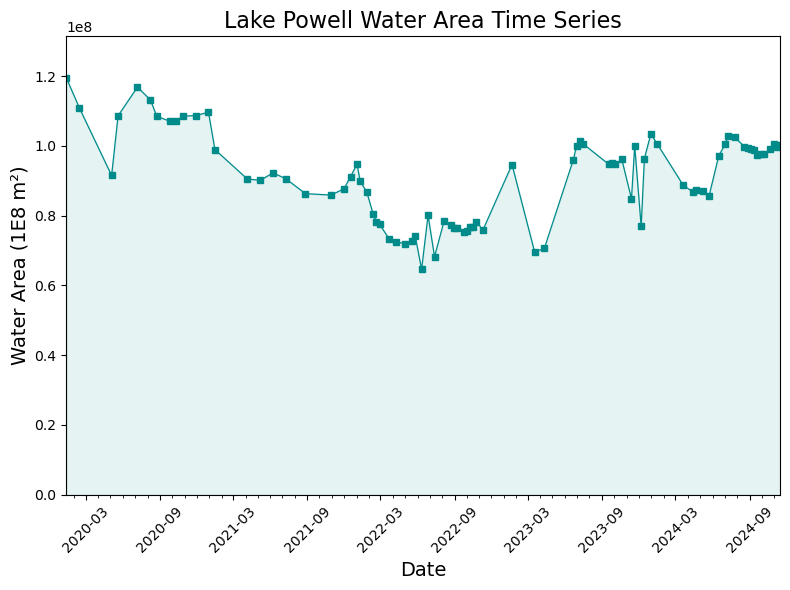

In [8]:
plt.figure(figsize=(8, 6)) # Set figure size
plt.plot(water_area_df['Date'], water_area_df['water_area_m2'], marker='s', markersize=5, linewidth=0.9, color='darkcyan') # Plot water area time series
plt.fill_between(water_area_df['Date'], water_area_df['water_area_m2'], color='darkcyan', alpha=0.1) # Fill area under the curve
plt.title('Lake Powell Water Area Time Series', fontsize=16) # Set plot title
plt.xlabel('Date', fontsize=14) # Set x-axis label
plt.ylabel('Water Area (1E8 m²)', fontsize=14) # Set y-axis label
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.gca().xaxis.set_major_locator(MonthLocator(interval=6))  # Limit major x-ticks to every 6 months
plt.gca().xaxis.set_minor_locator(MonthLocator(interval=1))  # Limit minor x-ticks to every month
plt.xlim(water_area_df['Date'].min(), water_area_df['Date'].max())  # Set x-axis limits
plt.ylim(0, water_area_df['water_area_m2'].max() * 1.1)  # Set y-axis limits
plt.tight_layout()
plt.show()  # Display the plot